# Transfer Learning
### 목표  
미세조정 학습에 대해 알아보고 처음부터 모델을 설계하는 것과 미세 조정 모델간의 차이에 대해 알아보자.
### 의의
아래에서 RA로 학습시킨 모델로 LA 데이터를 테스트하면 성능이 떨어진다. 이렇듯 도메인이 다른 데이터에 대해 일반화된 모델 성능이 좋지 않을 수 있다. 따라서 Transfer Learning은 Pre-trained model을 미세조정하여 Personal Model을 구축할 수 있다.

# Load Data

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import pandas as pd
from tqdm import tqdm

In [4]:
df = pd.read_csv('./datasets/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [5]:
df.shape

(9120, 272)

In [6]:
df['people'].unique()

array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8'], dtype=object)

In [7]:
df.isna().sum()

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64

In [8]:
df.columns

Index(['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std',
       'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var',
       ...
       'LL_ymag_std', 'LL_ymag_skew', 'LL_zmag_mean', 'LL_zmag_max',
       'LL_zmag_min', 'LL_zmag_var', 'LL_zmag_std', 'LL_zmag_skew', 'activity',
       'people'],
      dtype='object', length=272)

In [9]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

Text(0, 0.5, 'Count')

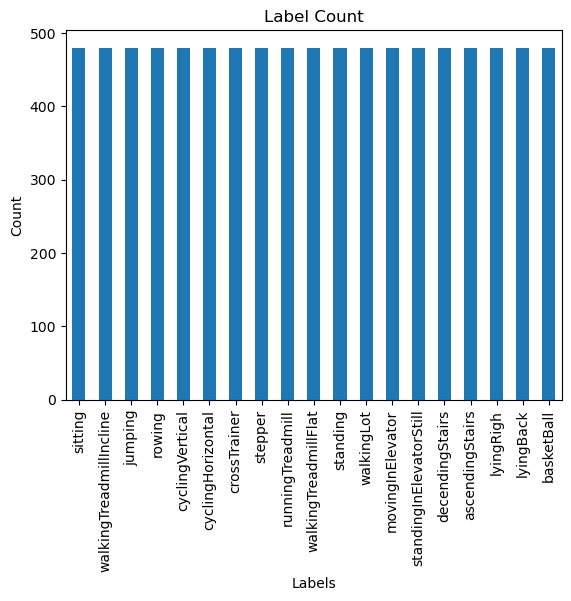

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 레이블별 갯수 확인
label_counts = df['activity'].value_counts()

# 바 그래프 그리기
label_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')

## RA, LA 데이터 분리

In [12]:
df_RA = df.filter(regex='RA_') # 오른팔
df_LA = df.filter(regex='LA_') # 왼팔 

In [13]:
df_RA.insert(3, 'activity', df['activity'])
df_LA.insert(3, 'activity', df['activity'])

In [14]:
df_RA.head()

,RA_xacc_mean,RA_xacc_max,RA_xacc_min,activity,RA_xacc_var,RA_xacc_std,RA_xacc_skew,RA_yacc_mean,RA_yacc_max,RA_yacc_min,...,RA_ymag_min,RA_ymag_var,RA_ymag_std,RA_ymag_skew,RA_zmag_mean,RA_zmag_max,RA_zmag_min,RA_zmag_var,RA_zmag_std,RA_zmag_skew
0,0.679134,0.75930,0.58542,sitting,0.001546,0.039324,-0.415694,5.713088,5.8483,5.5956,...,-0.57428,0.000012,0.003401,-0.052190,-0.211136,-0.18401,-0.24523,0.000044,0.006638,-1.153902
1,0.644964,0.73158,0.53064,sitting,0.001333,0.036508,0.410625,5.795154,5.9546,5.6687,...,-0.57398,0.000005,0.002216,0.222740,-0.206431,-0.18054,-0.23624,0.000032,0.005660,0.458427
2,0.608212,0.67737,0.53546,sitting,0.000637,0.025244,0.153302,5.833086,5.8918,5.7656,...,-0.57563,0.000004,0.001954,-0.221765,-0.205648,-0.18342,-0.22933,0.000024,0.004868,-0.984915
3,0.591138,0.71177,0.51524,sitting,0.001349,0.036731,0.525019,5.863846,5.9645,5.7556,...,-0.57858,0.000007,0.002688,0.075011,-0.203739,-0.17999,-0.22958,0.000026,0.005099,0.185634
4,0.558168,0.67190,0.50535,sitting,0.000626,0.025020,1.076782,5.884745,5.9401,5.8384,...,-0.57996,0.000005,0.002278,-0.219440,-0.203684,-0.17904,-0.22924,0.000027,0.005175,-0.820907


In [15]:
df_LA.head()

,LA_xacc_mean,LA_xacc_max,LA_xacc_min,activity,LA_xacc_var,LA_xacc_std,LA_xacc_skew,LA_yacc_mean,LA_yacc_max,LA_yacc_min,...,LA_ymag_min,LA_ymag_var,LA_ymag_std,LA_ymag_skew,LA_zmag_mean,LA_zmag_max,LA_zmag_min,LA_zmag_var,LA_zmag_std,LA_zmag_skew
0,3.403317,3.4875,3.2682,sitting,0.001583,0.039790,-0.744647,-8.375713,-8.2927,-8.4821,...,0.33748,0.000003,0.001810,-0.215069,0.072273,0.076374,0.067940,0.000004,0.001910,-0.166015
1,3.427302,3.6630,3.3168,sitting,0.004305,0.065614,1.000107,-8.397591,-8.3118,-8.5017,...,0.33000,0.000017,0.004159,-0.611251,0.074557,0.085184,0.068169,0.000022,0.004643,0.717286
2,3.400870,3.5168,3.3315,sitting,0.001007,0.031732,0.978319,-8.439138,-8.3599,-8.5204,...,0.33307,0.000002,0.001316,-0.506255,0.075852,0.083227,0.072507,0.000004,0.002106,1.043919
3,3.391002,3.5311,3.2608,sitting,0.001792,0.042328,0.117935,-8.441421,-8.3207,-8.5446,...,0.33431,0.000002,0.001395,0.155251,0.074878,0.080059,0.069942,0.000006,0.002414,0.242524
4,3.359974,3.4434,3.3069,sitting,0.000633,0.025160,1.051627,-8.454854,-8.3202,-8.5561,...,0.33631,0.000001,0.001005,-0.299017,0.073398,0.077461,0.070175,0.000002,0.001482,0.606258


In [16]:
df_LA['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [17]:
df_RA['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_RA['activity'] = label_encoder.fit_transform(df_RA['activity'])

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()
# 'label' 컬럼을 숫자로 변환
df_LA['activity'] = label_encoder.fit_transform(df_LA['activity'])

C:\Users\user\AppData\Local\Temp\ipykernel_9720\3441972880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RA['activity'] = label_encoder.fit_transform(df_RA['activity'])
C:\Users\user\AppData\Local\Temp\ipykernel_9720\3441972880.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LA['activity'] = label_encoder.fit_transform(df_LA['activity'])


In [19]:
df_LA['activity'].value_counts()

activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64

In [20]:
df_RA['activity'].value_counts()

activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64

## Train, Test 분리 - LA, RA

In [22]:
# Right Arm
df_RA_Y=df_RA['activity']

In [23]:
df_RA_X=df_RA.drop('activity',axis=1)
df_RA_X.head()

,RA_xacc_mean,RA_xacc_max,RA_xacc_min,RA_xacc_var,RA_xacc_std,RA_xacc_skew,RA_yacc_mean,RA_yacc_max,RA_yacc_min,RA_yacc_var,...,RA_ymag_min,RA_ymag_var,RA_ymag_std,RA_ymag_skew,RA_zmag_mean,RA_zmag_max,RA_zmag_min,RA_zmag_var,RA_zmag_std,RA_zmag_skew
0,0.679134,0.75930,0.58542,0.001546,0.039324,-0.415694,5.713088,5.8483,5.5956,0.003779,...,-0.57428,0.000012,0.003401,-0.052190,-0.211136,-0.18401,-0.24523,0.000044,0.006638,-1.153902
1,0.644964,0.73158,0.53064,0.001333,0.036508,0.410625,5.795154,5.9546,5.6687,0.001132,...,-0.57398,0.000005,0.002216,0.222740,-0.206431,-0.18054,-0.23624,0.000032,0.005660,0.458427
2,0.608212,0.67737,0.53546,0.000637,0.025244,0.153302,5.833086,5.8918,5.7656,0.000488,...,-0.57563,0.000004,0.001954,-0.221765,-0.205648,-0.18342,-0.22933,0.000024,0.004868,-0.984915
3,0.591138,0.71177,0.51524,0.001349,0.036731,0.525019,5.863846,5.9645,5.7556,0.001423,...,-0.57858,0.000007,0.002688,0.075011,-0.203739,-0.17999,-0.22958,0.000026,0.005099,0.185634
4,0.558168,0.67190,0.50535,0.000626,0.025020,1.076782,5.884745,5.9401,5.8384,0.000471,...,-0.57996,0.000005,0.002278,-0.219440,-0.203684,-0.17904,-0.22924,0.000027,0.005175,-0.820907


In [24]:
from sklearn.model_selection import train_test_split

X_train_RA, X_test_RA, y_train_RA, y_test_RA = train_test_split(df_RA_X, 
                                                    df_RA_Y,
                                                    test_size = 0.25, 
                                                    random_state = 21)

In [25]:
# Left Arm
df_LA_Y = df_LA['activity']
df_LA_Y.head()

0    12
1    12
2    12
3    12
4    12
Name: activity, dtype: int32

In [26]:
df_LA_X=df_LA.drop('activity',axis=1)
df_LA_X.head()

,LA_xacc_mean,LA_xacc_max,LA_xacc_min,LA_xacc_var,LA_xacc_std,LA_xacc_skew,LA_yacc_mean,LA_yacc_max,LA_yacc_min,LA_yacc_var,...,LA_ymag_min,LA_ymag_var,LA_ymag_std,LA_ymag_skew,LA_zmag_mean,LA_zmag_max,LA_zmag_min,LA_zmag_var,LA_zmag_std,LA_zmag_skew
0,3.403317,3.4875,3.2682,0.001583,0.039790,-0.744647,-8.375713,-8.2927,-8.4821,0.001178,...,0.33748,0.000003,0.001810,-0.215069,0.072273,0.076374,0.067940,0.000004,0.001910,-0.166015
1,3.427302,3.6630,3.3168,0.004305,0.065614,1.000107,-8.397591,-8.3118,-8.5017,0.001098,...,0.33000,0.000017,0.004159,-0.611251,0.074557,0.085184,0.068169,0.000022,0.004643,0.717286
2,3.400870,3.5168,3.3315,0.001007,0.031732,0.978319,-8.439138,-8.3599,-8.5204,0.000684,...,0.33307,0.000002,0.001316,-0.506255,0.075852,0.083227,0.072507,0.000004,0.002106,1.043919
3,3.391002,3.5311,3.2608,0.001792,0.042328,0.117935,-8.441421,-8.3207,-8.5446,0.001862,...,0.33431,0.000002,0.001395,0.155251,0.074878,0.080059,0.069942,0.000006,0.002414,0.242524
4,3.359974,3.4434,3.3069,0.000633,0.025160,1.051627,-8.454854,-8.3202,-8.5561,0.001061,...,0.33631,0.000001,0.001005,-0.299017,0.073398,0.077461,0.070175,0.000002,0.001482,0.606258


In [27]:
from sklearn.model_selection import train_test_split

X_train_LA, X_test_LA, y_train_LA, y_test_LA = train_test_split(df_LA_X, 
                                                    df_LA_Y,
                                                    test_size = 0.25, 
                                                    random_state = 21)

In [28]:
X_train_RA.shape, X_test_RA.shape, y_train_RA.shape, y_test_RA.shape

((6840, 54), (2280, 54), (6840,), (2280,))

In [29]:
X_train_LA.shape, X_test_LA.shape, y_train_LA.shape, y_test_LA.shape

((6840, 54), (2280, 54), (6840,), (2280,))

## 순환 데이터 전환 & One-Hot Encode Target Variable

Split Seuqence -> 순환형 데이터

In [32]:
from collections import Counter
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [33]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array_RA = np.array(y_train_RA)
train_set_RA = np.c_[X_train_RA, y_train_array_RA]

y_test_array_RA = np.array(y_test_RA)
test_set_RA = np.c_[X_test_RA, y_test_array_RA]

In [34]:
n_step = 3 

X_train_seq_RA, y_train_seq_RA = split_sequences(train_set_RA, n_step)
print(X_train_seq_RA.shape, y_train_seq_RA.shape)

X_test_seq_RA, y_test_seq_RA = split_sequences(test_set_RA, n_step)
print(X_test_seq_RA.shape, y_test_seq_RA.shape)

(6838, 3, 54) (6838,)
(2278, 3, 54) (2278,)


In [35]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array_LA = np.array(y_train_LA)
train_set_LA = np.c_[X_train_LA, y_train_array_LA]

y_test_array_LA = np.array(y_test_LA)
test_set_LA = np.c_[X_test_LA, y_test_array_LA]

In [36]:
n_step = 3 

X_train_seq_LA, y_train_seq_LA = split_sequences(train_set_LA, n_step)
print(X_train_seq_LA.shape, y_train_seq_LA.shape)

X_test_seq_LA, y_test_seq_LA = split_sequences(test_set_LA, n_step)
print(X_test_seq_LA.shape, y_test_seq_LA.shape)

(6838, 3, 54) (6838,)
(2278, 3, 54) (2278,)


One-Hot Encode target variable

In [38]:
from keras.utils import to_categorical

# Convert output variables to categorical for CNN
y_train_seq_RA = to_categorical(y_train_seq_RA)
print(y_train_seq_RA.shape)

y_test_seq_RA = to_categorical(y_test_seq_RA)
print(y_test_seq_RA.shape)

(6838, 19)
(2278, 19)


In [39]:
# Convert output variables to categorical for CNN
y_train_seq_LA = to_categorical(y_train_seq_LA)
print(y_train_seq_LA.shape)

y_test_seq_LA = to_categorical(y_test_seq_LA)
print(y_test_seq_LA.shape)

(6838, 19)
(2278, 19)


In [40]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train_seq_RA.shape[1], X_train_seq_RA.shape[2], y_train_seq_RA.shape[1]
print(n_timesteps, n_features, n_outputs)

3 54 19


# Model Structure

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D

## (1) 처음부터 모델 설계

In [44]:
# Build CNN model using keras. For model building suggestions, referenced:
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model = Sequential()
model.add(LSTM(units=128, input_shape = (n_timesteps,n_features)))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(X_train_seq_RA, y_train_seq_RA, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.2254 - loss: 2.4951 - val_accuracy: 0.5132 - val_loss: 1.4399
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6179 - loss: 1.1675 - val_accuracy: 0.7456 - val_loss: 0.9557
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7668 - loss: 0.7861 - val_accuracy: 0.7602 - val_loss: 0.8366
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8140 - loss: 0.6152 - val_accuracy: 0.8099 - val_loss: 0.7256
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8635 - loss: 0.4693 - val_accuracy: 0.8392 - val_loss: 0.6505
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8806 - loss: 0.4145 - val_accuracy: 0.7968 - val_loss: 0.7033
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9042 - loss: 0.3431 - val_accuracy: 0.8523 - val_loss: 0.6060
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9288 - loss: 0.2656 - val_accu

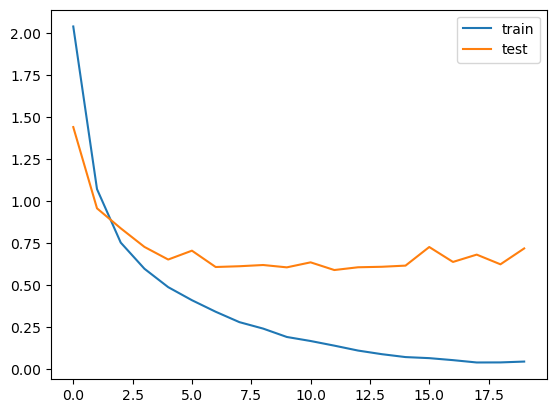

In [47]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

In [48]:
model.evaluate(X_train_seq_RA, y_train_seq_RA)

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0315


[0.09682253748178482, 0.9808423519134521]

In [49]:
model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8661 - loss: 0.6853


[0.7019371390342712, 0.859964907169342]

Confusion matrix

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Confusion Matrix


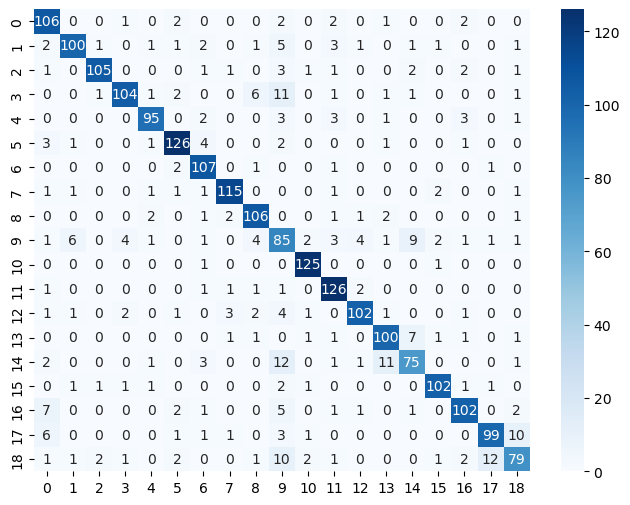

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq_RA, axis=1)
Y_pred = np.argmax(model.predict(X_test_seq_RA),axis=1)

print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()

In [52]:
base_loss,base_accuracy=model.evaluate(X_test_seq_RA, y_test_seq_RA)

model_file='./datasets/RA_Model.keras'
  
tf.keras.models.save_model(model, model_file, include_optimizer=False)
print('model saved at ', model_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8661 - loss: 0.6853
model saved at  ./datasets/RA_Model.keras
Accuracy >85.996491
Base Loss >0.70


In [53]:
# Build CNN model using keras. For model building suggestions, referenced:
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model2 = Sequential()
model2.add(LSTM(units=128, input_shape = (n_timesteps,n_features)))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(n_outputs, activation='softmax'))
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history2 = model2.fit(X_train_seq_LA, y_train_seq_LA, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.2303 - loss: 2.5115 - val_accuracy: 0.6213 - val_loss: 1.2406
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6574 - loss: 1.0718 - val_accuracy: 0.7558 - val_loss: 0.8660
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7918 - loss: 0.7180 - val_accuracy: 0.7997 - val_loss: 0.7433
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8579 - loss: 0.5277 - val_accuracy: 0.8304 - val_loss: 0.6257
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8803 - loss: 0.4388 - val_accuracy: 0.8377 - val_loss: 0.5837
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8949 - loss: 0.3553 - val_accuracy: 0.8655 - val_loss: 0.5463
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9187 - loss: 0.2942 - val_accuracy: 0.8582 - val_loss: 0.5253
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9335 - loss: 0.2328 - val_acc

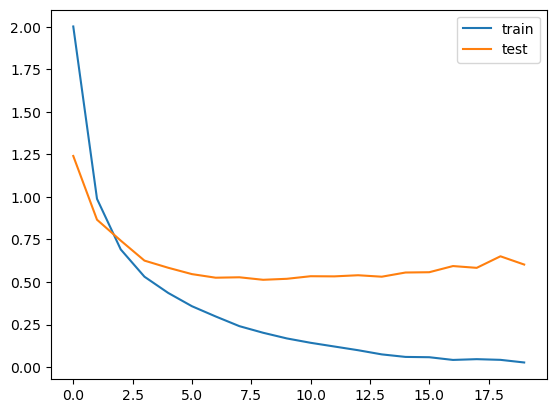

In [56]:
plt.plot(history2.history["loss"], label = "train")
plt.plot(history2.history["val_loss"], label = "test")
plt.legend()

In [57]:
model2.evaluate(X_train_seq_LA, y_train_seq_LA)

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9983 - loss: 0.0181


[0.07338989526033401, 0.9859607815742493]

In [58]:
model2.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8908 - loss: 0.5200


[0.550441563129425, 0.885864794254303]

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Confusion Matrix


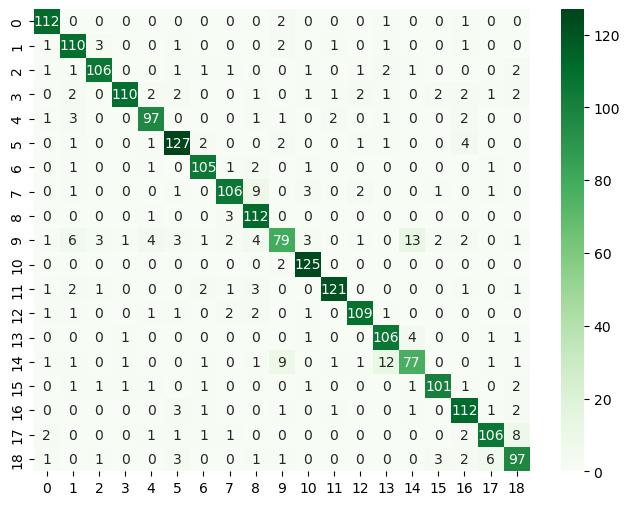

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq_LA, axis=1)
Y_pred = np.argmax(model2.predict(X_test_seq_LA),axis=1)

print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

# 그래프 표시
plt.show()

In [60]:
base_loss,base_accuracy=model2.evaluate(X_test_seq_LA, y_test_seq_LA)

model_file2='./datasets/LA_Model.keras'
  
tf.keras.models.save_model(model2, model_file2, include_optimizer=False)
print('model saved at ', model_file2)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8908 - loss: 0.5200
model saved at  ./datasets/LA_Model.keras
Accuracy >88.586479
Base Loss >0.55


학습시킨 LA 모델은 model_file 위치에, RA 모델 model_file2 위치에 저장해놓았다.  
바로 아래에서 로드하여 전이학습 및 미세조정에 사용할 것이다.

## (2) 전이 학습 및 미세 조정
### Load LA Model and Evaluate

로드한 LA 모델을 basemodel로 하여 모델을 만들고 RA 데이터를 학습시킬 것이다.  
이로서 효율적으로 학습시키고, 파인 튜닝을 통해 정교화해보자.  
이때, pretrained model의 Output layer는 제외한 후 층을 쌓아야 한다.  

In [154]:
# Base 모델을 로드 (LA_Model.keras)
from tensorflow.keras.models import load_model

base_model = load_model(model_file2)

In [156]:
base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8908 - loss: 0.5200


[0.550441563129425, 0.885864794254303]

In [158]:
base_model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2473 - loss: 5.9017


[5.7189788818359375, 0.25417032837867737]

로드한 LA 모델을 LA 데이터로 평가하면 88%의 정확도를 보이며, RA 데이터로 평가하면 22%의 정확도로 현저히 낮아짐을 보인다.  
하지만, 비슷한 도메인이니 LA Model을 BaseModel로 하여 학습한다면, train cost가 줄 것이다.

In [161]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  3


## Pretrained Model - LA

In [164]:
# 기존 모델 구조
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
def remove_last_layers(model, num_layers_to_remove):
    # 모델의 레이어를 하나씩 슬라이스해서 앞의 레이어만 가져옴
    model_layers = model.layers[:-num_layers_to_remove]  # 마지막 레이어부터 지정된 갯수만큼 제외
    new_model = models.Sequential(model_layers)  # 새로운 모델에 해당 레이어들만 추가
    return new_model

In [169]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 기존 모델의 층을 동결 (학습되지 않도록 설정)
base_model.trainable = False

new_model = remove_last_layers(base_model, 1)

# 새로운 완전연결층 추가
new_model.add(layers.Dense(64, activation='relu'))  # 기존 출력층 앞의 레이어 대신 추가

# 최종 출력층 추가 (예: 10개의 클래스)
new_model.add(layers.Dense(19, activation='softmax'))

new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# 모델 요약 출력
new_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,208 (430.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 110,208 (430.50 KB)

In [171]:
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<LSTM name=lstm_1, built=True>",lstm_1,False
1,"<Dense name=dense_2, built=True>",dense_2,False
2,"<Dense name=dense_8, built=False>",dense_8,True
3,"<Dense name=dense_9, built=False>",dense_9,True


LA 데이터로 학습된 모델을 base model로 사용한 모델을 RA 데이터로 학습한다.

In [173]:
history3 = new_model.fit(X_train_seq_RA, y_train_seq_RA, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2642 - loss: 2.4946 - val_accuracy: 0.4971 - val_loss: 1.6461
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5049 - loss: 1.5984 - val_accuracy: 0.5044 - val_loss: 1.4969
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5467 - loss: 1.4717 - val_accuracy: 0.5292 - val_loss: 1.4010
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5613 - loss: 1.3918 - val_accuracy: 0.5526 - val_loss: 1.3788
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5776 - loss: 1.3256 - val_accuracy: 0.5585 - val_loss: 1.3331
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5872 - loss: 1.2792 - val_accuracy: 0.5804 - val_loss: 1.3011
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5995 - loss: 1.2709 - val_accuracy: 0.5687 - val_loss: 1.3212
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6083 - loss: 1.2153 - val_accuracy: 

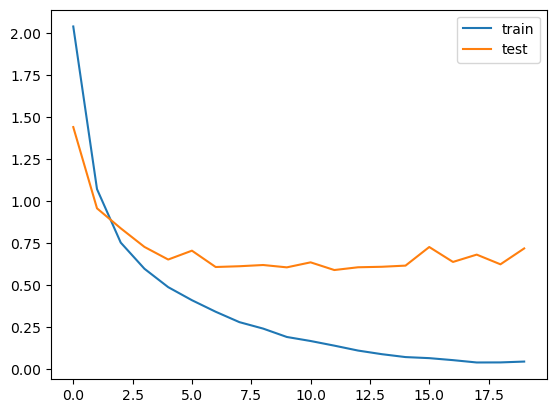

In [76]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

이전에 비해 정확도는 0.2에서 0.6으로 향상되었다. 하지만 LA 데이터로 학습되어 있었기에 RA 데이터에 대해 여전히 오차를 보임을 알 수 있다.  
이를 정교화하기 위해 base_model의 Trainable을 True로 설정 후 다시 학습시켜 정교화해보겠다. 이를 파인튜닝이라고 한다.

### 파인튜닝

In [178]:
# 베이스 모델의 층을 동결 해제
base_model.trainable = True

# 다시 컴파일 (변경된 모델 구조에 대해 재컴파일 필요)
new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# 파인튜닝 (동결 해제된 레이어를 학습)
new_model.fit(X_train_seq_RA, y_train_seq_RA, epochs=5, batch_size=32, validation_split=0.2)

# 모델 평가
new_model.evaluate(X_test_seq_RA, y_test_seq_RA)

Epoch 1/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7222 - loss: 0.9066 - val_accuracy: 0.7602 - val_loss: 0.7963
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8346 - loss: 0.5614 - val_accuracy: 0.7990 - val_loss: 0.6937
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8684 - loss: 0.4400 - val_accuracy: 0.8056 - val_loss: 0.6766
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9081 - loss: 0.3182 - val_accuracy: 0.8092 - val_loss: 0.6770
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9278 - loss: 0.2629 - val_accuracy: 0.8238 - val_loss: 0.6656
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8291 - loss: 0.6484


[0.6601464152336121, 0.8279192447662354]

파인튜닝을 거친 후 정확도가 현저히 증가함을 확인할 수 있다.

## Load RA Model & Evaluate

위와 같은 작업을 RA 모델을 로드해와 진행해보자.

In [201]:
# Base 모델을 로드 (RA_Model.keras)
from tensorflow.keras.models import load_model

base_model = load_model(model_file)

In [203]:
base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8661 - loss: 0.6853


[0.7019371390342712, 0.859964907169342]

In [204]:
base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2162 - loss: 7.8540


[7.883860111236572, 0.21553994715213776]

RA 모델 또한 RA 데이터에 대해선 87%로 비교적 높은 정확도를, LA 데이터에 대해선 23%롤 낮은 정확도를 보인다.

### Pretrained Model - RA

In [206]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 기존 모델의 층을 동결 (학습되지 않도록 설정)
base_model.trainable = False

new_model = remove_last_layers(base_model, 1)

# 새로운 완전연결층 추가
new_model.add(layers.Dense(64, activation='relu'))  # 기존 출력층 앞의 레이어 대신 추가

# 최종 출력층 추가 (예: 10개의 클래스)
new_model.add(layers.Dense(19, activation='softmax'))

new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# 모델 요약 출력
new_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          93,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,208 (430.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 110,208 (430.50 KB)

In [207]:
history3 = new_model.fit(X_train_seq_LA, y_train_seq_LA, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2560 - loss: 2.4764 - val_accuracy: 0.4839 - val_loss: 1.5933
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5202 - loss: 1.5083 - val_accuracy: 0.5190 - val_loss: 1.4204
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5514 - loss: 1.3857 - val_accuracy: 0.5629 - val_loss: 1.3383
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5903 - loss: 1.2701 - val_accuracy: 0.5673 - val_loss: 1.3101
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5961 - loss: 1.2354 - val_accuracy: 0.5965 - val_loss: 1.2744
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6041 - loss: 1.2118 - val_accuracy: 0.5994 - val_loss: 1.2313
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6193 - loss: 1.1590 - val_accuracy: 0.5789 - val_loss: 1.2391
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6195 - loss: 1.1557 - val_accuracy: 

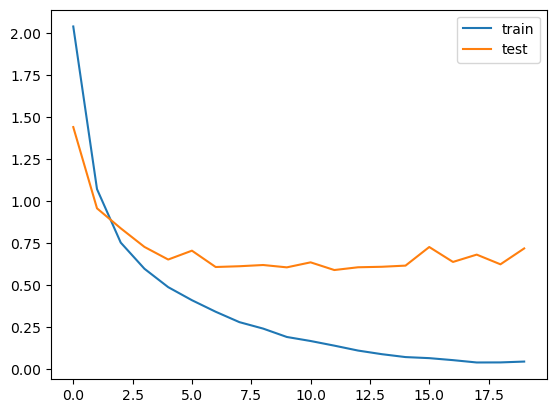

In [208]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

RA 데이터로 학습된 모델을 베이스 모델로 하여 모델을 만든 후 LA 데이터로 학습했더니 역시 정확도가 0.2에서 0.7로 향상되었으나 여전히 오차가 존재한다.  
이를 파인튜닝으로 개선해보자.

#### 미세조정

- 파인튜닝
  trainable=True로 설정하여 최적화하는 작업

In [211]:
# 베이스 모델의 층을 동결 해제
base_model.trainable = True

# 다시 컴파일 (변경된 모델 구조에 대해 재컴파일 필요)
new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# 파인튜닝 (동결 해제된 레이어를 학습)
new_model.fit(X_train_seq_LA, y_train_seq_LA, epochs=5, batch_size=32, validation_split=0.2)

# 모델 평가
new_model.evaluate(X_test_seq_LA, y_test_seq_LA)

Epoch 1/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.7168 - loss: 0.8491 - val_accuracy: 0.7880 - val_loss: 0.7287
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8346 - loss: 0.5344 - val_accuracy: 0.8107 - val_loss: 0.6519
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8888 - loss: 0.3828 - val_accuracy: 0.8173 - val_loss: 0.6404
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9101 - loss: 0.3105 - val_accuracy: 0.8392 - val_loss: 0.6125
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9288 - loss: 0.2382 - val_accuracy: 0.8480 - val_loss: 0.5915
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8300 - loss: 0.6432


[0.6586741209030151, 0.8270412683486938]

### 미세조정과 처음부터 모델을 만들어서 학습한 것과의 차이

 앞서 우리는 미세 조정 학습을 위해, 학습된 모델을 로드해오고 모델의 output layer를 제거 후 층을 쌓았다. 학습된 모델의 가중치는 변화면 안되기 때문에 trainable=False를 통해 동결시켰다. 여기서 미세 조정의 이점을 파악할 수 있다. (학습을 통해 로드된 모델의 가중치가 변하면 로드해오는 의미가 없다.)
1. **학습 시간 단축**  
    이미 학습된 일반적인 특성을 재학습하지 않아도 되어 학습 속도가 크게 향상된다.  
   수업시간에 5개의 layer를 쌓았을 때 10만개의 parameter를 학습한다. 더 복잡한 모델일 수록 parameter 수가 기하급수적으로 증가할 것을 생각해보면 미세조정 학습의 장점을 쉽게 알 수 있다.
   앞의 layer는 일반적 특성을 추출한다고 했다. 근데 이를 처음부터 설계하고 학습한다? 너무 낭비다.
1. **효율적인 학습 시작점**  
   처음부터 모델을 설계하고, 학습을 시키면 알다시피 초기 가중치는 랜덤하게 설정되고 반복된 학습을 통해 오차를 최소화 하는 가중치를 찾는다. 미세조정 방식은 이미 잘 학습된 모델을 로드하고 동결시킴으로써, 위 과정을 생략한다. 이로써 유리한 시작점에서 학습을 진행하므로 효율적인 학습이 가능하다.
   